In [24]:
import cv2
import numpy as np
import os
import yaml
from yaml.loader import SafeLoader
import matplotlib.pyplot as plt

In [25]:
# Load yaml
with open('data.yaml', mode='r') as f:
    data_yaml = yaml.load(f, Loader=SafeLoader)
    
labels = data_yaml['names']

print(labels)

['bicycle', 'bus', 'car', 'person', 'truck']


In [26]:
# Load yolo model

yolo = cv2.dnn.readNetFromONNX('./Model/weights/best.onnx')

yolo.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
yolo.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [50]:
# Load the image

img = cv2.imread('street.jpeg')
image = img.copy()

row, col, d = image.shape

# get the yolo prediction of the image

max_rc = max(row, col)
input_image = np.zeros((max_rc, max_rc, 3), dtype = np.uint8)
input_image[0:row, 0:col] = image

INPUT_WH_YOLO = 640
blob = cv2.dnn.blobFromImage(input_image, 1/255, (INPUT_WH_YOLO, INPUT_WH_YOLO), swapRB = True, crop = False)
yolo.setInput(blob)
preds = yolo.forward()

In [51]:
# non maximum suppression
# step 1 : filter detection based on confidence score (0.4) and probability score (0.25)
detections = preds[0]
boxes = []
confidences = []
classes = []

# w and h of img

image_w, image_h = input_image.shape[:2]
x_factor = image_w / INPUT_WH_YOLO
y_factor = image_h / INPUT_WH_YOLO

for i in range(len(detections)):
    row = detections[i]
    confidence = row[4]
    
    if confidence > 0.4:
        class_score = row[5:].max()
        class_id = row[5:].argmax()
        
        if class_score > 0.25:
            cx, cy, w, h = row[0:4]
            left = int((cx - 0.5*w)*x_factor)
            top = int((cy - 0.5*h)*y_factor)
            width = int(w*x_factor)
            height = int(h*y_factor)
            
            box = np.array([left, top, width, height])
            
            confidences.append(confidence)
            boxes.append(box)
            classes.append(class_id)  
            
boxes_np = np.array(boxes).tolist()
confidences_np = np.array(confidences).tolist()

index = np.array(cv2.dnn.NMSBoxes(boxes_np, confidences_np, 0.25, 0.45)).flatten()

In [52]:
for ind in index:
    x,y,w,h = boxes_np[ind]
    bb_conf = int(confidences_np[ind]*100)
    classes_id = classes[ind]
    class_name = labels[classes_id]
    
    text = f'{class_name}: {bb_conf}'
    
    cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)
    cv2.rectangle(image, (x, y-40), (x+w, y), (255,255,255), -1)
    cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 3, (0,0,0), 2)

In [53]:
# cv2.imshow('original', img)
# cv2.imshow('yolo prediction', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

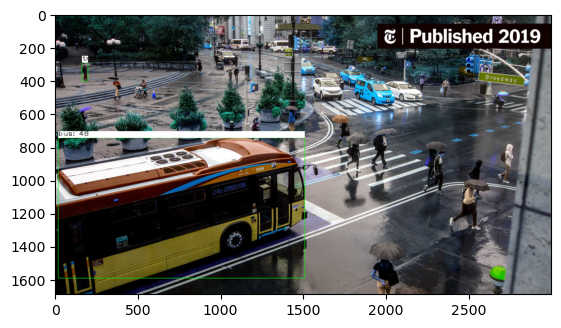

In [54]:
plt.imshow(image)